In [1]:
import numpy as np 
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.html'] = 'jshtml'


def calc_perc_temp(src): 
    # number of valid nodes above minimum ice-thickness
    # NN = src.height.where(src.height < 10).count(dim=('nMesh_node'))#.count(dim=('coord_1', 'coord_2'))
    NN = src.height.where(src.height > 10).count(dim=('coord_1', 'coord_2'))

    # mask for determining where nodes are temperate 
    mask = (src['enthalpy_h'] > src['phase change enthalpy']) & (src.height > 10)
    # number of nodes where ethalpy exceeds phase chnage enthalpy
    NT = src.enthalpy_h.where(mask).count(dim=('coord_1', 'coord_2'))
    return NT/NN * 100



def load_runs(fp, t_f=2000): 
    arrays = []

    for dt in [1.0, 0.5, 0.25, 0.1]: 
        # open both the heat source datasets for the given timesteps
        src = xr.open_dataset(fp.format(int(t_f/dt), dt))
        # a little basic prepocessing 
        src = src.isel(Delta_MB=0, T_ma=0)
        src = src.rename({"t":"time"})
    
#         if 1/src.dt != 1: 
#             src = src.coarsen(time=10,boundary='trim').mean()
#             src['time'] = np.floor(src.time)

#         src['time'] = src.time * 365
#         src.time.attrs = {"units": "days since 0001-01-01"}    
#         # Decode the timestamp 
#         src = xr.decode_cf(src, use_cftime=True)
        # Take the annual averages 
        # src = src.groupby('time.year').mean()
        
        
        src['vol'] = src.height.isel(coord_2 = -1).integrate('coord_1') /\
                     src.height.isel(coord_2 = -1, time= 0).integrate('coord_1')
        
        arrays.append(src)
    return arrays
    # return xr.concat(arrays, 'dt')

In [ ]:
# fp = 'glc1-a/nc/glc1-a_dx_50_NT_{}_dt_{}_volumetric_prog_gridded.nc'
# season_vol = load_runs(fp) 

In [2]:
fp = 'glc1-a/nc/glc1-a_dx_50_NT_{}_dt_{}_volumetric_prog_gridded.nc'

# files = [fp.format(int(2000/dt), dt) for dt in [1.0, 0.5, 0.25, 0.1]]

test = load_runs(fp)

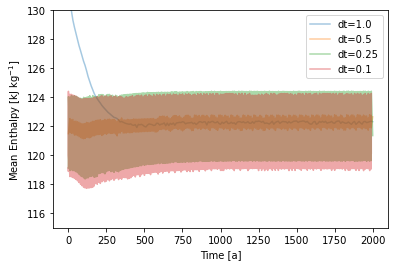

In [3]:
fig, ax = plt.subplots(1,1)

for i, dt in enumerate([1.0, 0.5, 0.25, 0.1]): 
    mean_enth = (test[i].isel(heat_source=0,dt=0).enthalpy_h.mean(('coord_1', 'coord_2'))/1e3)
    
    N = int(100 / dt)
    
    ax.plot(mean_enth.time, mean_enth, label=f'dt={dt}', alpha=0.4, )#np.minimum(1.0, dt/0.333))
    
ax.legend();
ax.set_ylabel('Mean Enthalpy [kJ kg$^{-1}$]');
ax.set_xlabel('Time [a]')
ax.set_ylim(115, 130)

fig.savefig('./figs/volumetric_seasonality_2kya.png', 
            bbox_inches='tight', facecolor='w', dpi= 400)

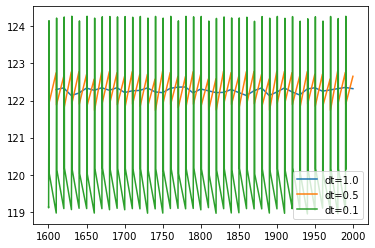

In [4]:
fig, ax = plt.subplots(1,1)

for i, dt in enumerate([1.0, 0.5, 0.25, 0.1]): 
    if i == 2: 
        continue
    mean_enth = (test[i].isel(heat_source=0,dt=0).enthalpy_h.mean(('coord_1', 'coord_2'))/1e3)
    
    N = int(40 / dt)
    mean_enth = mean_enth.isel(time=slice(-N, None))
    ax.plot(mean_enth.time, mean_enth, label=f'dt={dt}')
    
ax.legend()

In [6]:
enth = test[0].isel(heat_source=0, dt=0)


# element_enth = (enth.enthalpy_h[1:, 1:] + enth.enthalpy_h[:-1, :-1]) / 4 
# element_area = (enth.X[1:,1:] - enth.X[1:,:-1]) * (enth.Z[1:,1:] - enth.Z[:-1,1:])

In [7]:
# vertical spacing (dz) on left side of element 
l_dz = enth.Z.isel(coord_2=slice(1,None), coord_1=slice(1,None)) -\
       enth.Z.isel(coord_2=slice(0, -1),  coord_1=slice(1,None))
# vertical spacing (dz) on right side of element 
r_dz = enth.Z.isel(coord_2=slice(1,None), coord_1=slice(0, -1)) -\
       enth.Z.isel(coord_2=slice(0, -1),  coord_1=slice(0, -1))
# horizontal spacing (dx), average is used since horizontal grid is never updated
m_dx = (enth.X.isel(coord_2=slice(1,None), coord_1=slice(1, None)) -\
        enth.X.isel(coord_2=slice(1,None), coord_1=slice(0,  -1 ))).mean()
# Calculate the element area
element_area = (m_dx * (l_dz + r_dz) / 2).stack(element=('coord_2', 'coord_1'))

In [74]:
# dictionaries for indexing structured mesh
l_i   = dict(coord_2=slice(0, -1),  coord_1=slice(1,None))
l_ip1 = dict(coord_2=slice(1,None), coord_1=slice(1,None))
r_i   = dict(coord_2=slice(0, -1),  coord_1=slice(0, -1))
r_ip1 = dict(coord_2=slice(1,None), coord_1=slice(0, -1))


def element_mean(src, var): 
    field = src.get(var)
    
    # sum of field on left  side of element  
    l_s = field.isel(l_ip1) + field.isel(l_i)
    # sum of field on right side of element  
    r_s = field.isel(r_ip1) + field.isel(r_i)
    
    # return element averaged field 
    return ((l_s + r_s) / 4).stack(element=('coord_2', 'coord_1'))

def calc_element_area(src, var='height'):
    """Calculate element area of a structured mesh
    """
    dz_field = src.get(var)
    
    # vertical spacing (dz) on left side of element 
    l_dz = dz_field.isel(l_ip1) - dz_field.isel(l_i)
    # vertical spacing (dz) on right side of element 
    r_dz = dz_field.isel(r_ip1) - dz_field.isel(r_i)
    # horizontal spacing (dx), average is used since horizontal grid is never updated
    m_dx = (src.X.isel(l_ip1) - src.X.isel(r_ip1)).mean()
    
    # return the element area
    return (m_dx * (l_dz + r_dz) / 2).stack(element=('coord_2', 'coord_1'))
            
def calc_percent_temperate(src):
    """
    """
    # Calculate the element area using structured grid
    elm_area = calc_element_area(enth)
    # Calculate mean elemental enthalpy
    elm_enth = element_mean(enth, 'enthalpy_h')
    # Calculate mean elemental phase change enthalpy (pce)
    elm_PCE  = element_mean(enth, 'phase change enthalpy')

    # mask to determine temperate nodes
    mask = elm_enth >= elm_PCE

    # find total glacier area
    A_totl = elm_area.sum('element')
    # find total temperate area
    A_temp = xr.where(mask, elm_area, 0.0).sum('element')
    
    # convert to percentage
    return (A_temp / A_totl) * 100
    
# make sure the element area calc is close to fabien's answer
hacky  = calc_element_area(enth.isel(time=0), var='Z').values
fabien = enth.quad_elements_area.values
assert np.linalg.norm(hacky-fabien) < 1e-3

# Calculate the element area using structured grid
elm_area = calc_element_area(enth)
# Calculate mean elemental enthalpy
elm_enth = element_mean(enth, 'enthalpy_h')
# Calculate mean elemental phase change enthalpy (pce)
elm_PCE  = element_mean(enth, 'phase change enthalpy')

# mask to determine temperate nodes
mask = elm_enth >= elm_PCE

# find total glacier area
A_totl = elm_area.sum('element')
# find total temperate area
A_temp = xr.where(mask, elm_area, 0.0).sum('element')
# convert to percentage
P_temp = (A_temp / A_totl) * 100

# # l_e  = enth.enthalpy_h.isel(l_ip1) + enth.enthalpy_h
# r_e  = enth.enthalpy_h.isel(r_ip1) + enth.enthalpy_h.isel(r_i)

# l_dz =  enth.Z.isel(time=0).isel(l_ip1) - enth.Z.isel(time=0).isel(l_i)
# r_dz =  enth.Z.isel(time=0).isel(r_ip1) - enth.Z.isel(time=0).isel(r_i)
# m_dx = (enth.X.isel(l_ip1) - enth.X.isel(r_ip1)).mean()

# element_area = (m_dx * (l_dz + r_dz) / 2).stack(element=('coord_2', 'coord_1'))
# (l_e + r_e) / 4 
# enth.enthalpy_h.isel(coord_2=slice(1,None), coord_1=slice(1,None)) + enth.enthalpy_h.isel(coord_2=slice(0, -1),  coord_1=slice(0,-1))

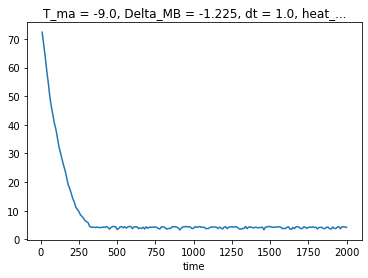

In [75]:
P_temp.plot()

In [76]:
assert np.linalg.norm(element_area.values - enth.quad_elements_area.values) <= 1e-3

In [ ]:
enth.quad_elements_area

In [ ]:
element_area.isel(time=0)

In [ ]:
tmp = enth.X[:,1:] - enth.X[:,:-1]
plt.imshow(tmp)
plt.colorbar()

In [ ]:
with xr.open_dataset('glc1-a/nc/glc1-a_dx_50_NT_2000_dt_1.0_volumetric_prog_gridded.nc') as src: 
    VOL = src.height.isel(coord_2 = -1).integrate('coord_1') /\
          src.height.isel(coord_2 = -1, t= 0).integrate('coord_1') 
    src = src.isel(heat_source=0, dt=0, Delta_MB=0, T_ma=0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,4))

im = ax.pcolormesh(src.X[:,::-1]/1e3, 
               src.Z.isel(t=-10), 
               src['temperature'].isel(t=-10), 
               shading='gouraud', 
               vmin=-8,
               # vmin=-8, 
            # vmax=0.03
                   )


fig.colorbar(im)
plt.xlim(0, 5.75)
plt.ylim(1.8e3, None)

fig.savefig('figs/Temp_Tma_-9.0_MB_-1.225_@2kya.png', dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
# test.isel(Delta_MB=0, T_ma=0, heat_source=0).enthalpy_h.mean(('coord_1', 'coord_2')).plot(x='year', hue='dt')


In [ ]:
VOL.plot()

In [ ]:
test = season_vol[0].height.isel(coord_2 = -1).integrate('coord_1') /\
       season_vol[0].height.isel(coord_2 = -1, year= 0).integrate('coord_1') 

In [ ]:
test.plot(x="year")

In [ ]:
fig, ax = plt.subplots()

# for i, dt  in enumerate([1.0, 0.5, 0.25, 0.1]):
for i, dt  in enumerate([5.0, 2.0, 1.0]):
        
    (season_vol[i].enthalpy_h.mean(('coord_2', 'coord_1'))/1e3).plot(x="time", marker='x', 
                                                                     ax=ax, label=f'dt={dt}')

plt.legend();
ax.set_title('Seasonality, Volumetric Heat Souce [J m$^{-3}$ a$^{-1}$]')
ax.set_ylabel('Mean Enthalpy [kJ kg$^{-1}$]');

ax.set_ylim(115, 130)


# fig.savefig('figs/mean_Enth_Season_Vol.png', 
#             dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
fp = 'glc1-a/nc/noSeasonality/glc1-a_dx_50_NT_*_dt_{}_volumetric_prog_gridded.nc'

noseason_vol = load_runs(fp) 

In [ ]:
fig, ax = plt.subplots()

for i, dt  in enumerate([1.0, 0.5, 0.25, 0.1]): 
    
    (noseason_vol[i].enthalpy_h.mean(('coord_2', 'coord_1'))/1e3).plot(x="year", marker='x', ax=ax, label=f'dt={dt}')

plt.legend()


ax.set_title('No Seasonality, Volumetric Heat Souce [J m$^{-3}$ a$^{-1}$]')
ax.set_ylabel('Mean Enthalpy [kJ kg$^{-1}$]');

ax.set_ylim(115, 130)


fig.savefig('figs/mean_Enth_noSeason_Vol.png', 
            dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
fp = 'glc1-a/nc/noSeasonality/glc1-a_dx_50_NT_*_dt_{}_mass_prog_gridded.nc'

noseason_mass = load_runs(fp) 

In [ ]:
fig, ax = plt.subplots()

for i, dt  in enumerate([1.0, 0.5, 0.25, 0.1]): 
    
    (noseason_mass[i].enthalpy_h.mean(('coord_2', 'coord_1'))/1e3).plot(x="year", marker='x', ax=ax, label=f'dt={dt}')

plt.legend();

ax.set_title('No Seasonality, Mass Heat Souce [J kg$^{-1}$ a$^{-1}$]')
ax.set_ylabel('Mean Enthalpy [kJ kg$^{-1}$]');

ax.set_ylim(115, 130)

fig.savefig('figs/mean_Enth_noSeason_Mass.png', 
            dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
# test = xr.open_mfdataset('glc1-a/nc/glc1-a_dx_50_NT_*_dt_*_*_prog_gridded.nc')

with xr.open_dataset('glc1-a/nc/glc1-a_dx_50_NT_500_dt_1.0_mass_prog_gridded.nc') as src: 
    src = src.sel(dt=1.0, heat_source='mass').isel(Delta_MB=0, T_ma=0)
    
    
    src['vol'] =src.height.isel(coord_2=-1).integrate("coord_1") /\
                src.height.isel(coord_2=-1,t=0).integrate("coord_1")
    
    src = src.rename({"t":"time"})
    src['time'] = np.floor(src.time * 365)
    src.time.attrs = {"units": "days since 2000-01-01"}    
    
    src = xr.decode_cf(src, use_cftime=True)
    
    
#     src.time.groupby('time.year').count(...).year

In [ ]:
test = xr.open_mfdataset('glc1-a/nc/glc1-a_dx_50_NT_*_dt_*_volumetric_prog_gridded.nc')

# Process time 
test = test.rename({"t":"time"})
# test['time'] = np.floor(test.time * 365)
# test.time.attrs = {"units": "days since 2000-01-01"}    

# test = xr.decode_cf(test, use_cftime=True)
    
    
# Calculate the relative volume
test['vol'] = test.height.isel(coord_2=-1).integrate("coord_1") /\
              test.height.isel(coord_2=-1, time=0).integrate("coord_1")
    
# test['Perc_temp'] = calc_perc_temp(test.isel(Delta_MB=0, T_ma=0))
test = test.isel(Delta_MB=0, T_ma=0)

In [ ]:
fig, ax = plt.subplots()

(test.enthalpy_h.mean(('coord_2', 'coord_1'))/1e3).sel(heat_source='volumetric').plot(x="time", hue='dt', ax=ax);

ax.set_ylim(112.5,130);

In [ ]:
test = xr.open_mfdataset('glc1-a/nc/noSeasonality/glc1-a_dx_50_NT_*_dt_0.25_*_prog_gridded.nc')
test = test.isel(Delta_MB=0, T_ma=0, dt=0)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True, 
                       constrained_layout=True)

norm = plt.Normalize(-10, 0.0)

ax[0].set_xlim(0, 5)
ax[0].set_ylim(1950, 3000)


# def init():
#     im = ax[i].pcolormesh(test.X[:,::-1]/1e3, 
#                      test.Z.sel(heat_source=heat_source).isel(t=0),
#                      test.temperature.sel(heat_source=heat_source).isel(t=0),
#                      shading='gouraud', 
#                      norm=norm)
#     im.set_array([])
#     return im

for i, heat_source in enumerate(test.heat_source): 
    im = ax[i].pcolormesh(test.X[:,::-1]/1e3, 
                     test.sel(heat_source=heat_source).Z.isel(t=0),
                     test.temperature.sel(heat_source=heat_source).isel(t=0),
                     shading='gouraud', 
                     norm=norm)

    # Fill between bed and bottom of plot
    ax[i].fill_between(test.X[0,::-1]/1e3,
                    test.sel(heat_source=heat_source).isel(t=0,coord_2=-1).zbed,
                    y2=np.minimum(test.sel(heat_source=heat_source).isel(t=0,coord_2=-1).zbed.min(), 0.0),
                    color='gray', alpha=0.5)

# Add time annotation
label = ax[0].text(0.9, 0.9, r"$t=0$",
                transform=ax[0].transAxes,
                ha='center', va='center')

# Set up the colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Homologous Temperature [$^\circ$ C]', rotation=270, labelpad=20)
        
def update(t):
    for i, heat_source in enumerate(test.heat_source): 
        
        # Wipe the axis
        ax[i].clear()
        im = ax[i].pcolormesh(test.X[:,::-1]/1e3, 
                         test.sel(heat_source=heat_source).Z.isel(t=t),
                         test.temperature.sel(heat_source=heat_source).isel(t=t),
                         shading='gouraud', 
                         norm=norm)


        # Fill between bed and bottom of plot
        ax[i].fill_between(test.X[0,::-1]/1e3,
                        test.sel(heat_source=heat_source).isel(t=0,coord_2=-1).zbed,
                        y2=np.minimum(test.sel(heat_source=heat_source).isel(t=0,coord_2=-1).zbed.min(), 0.0),
                        color='gray', alpha=0.5)
        # Update time annotation
        # label.set_text("$t={{{:6.1f}}}$".format(src.t[i].values))

        ax[i].set_title(str(heat_source.values))
        
    # Add time annotation
    label = ax[0].text(0.9, 0.9, "t={}".format(test.t[t].values),
                    transform=ax[0].transAxes,
                    ha='center', va='center')

    
    ax[0].set_xlim(0, 5)
    ax[0].set_ylim(1950, 3000)

ani = FuncAnimation(fig, update, frames=np.arange(2, 500, 10), interval=100)
plt.close()

In [ ]:
ani.save('figs/noSeasonality_dt_0.25.mp4', dpi=400)

In [ ]:
test = xr.open_mfdataset('glc1-a/nc/glc1-a_dx_50_NT_*_dt_*_*_prog_gridded.nc', 
                        compat="identical")

In [ ]:
test.heat_source

In [ ]:
src = test.isel(t=-1, Delta_MB=0, T_ma=0, dt=0)


fig, ax = plt.subplots(2,1) 

for i, heat_source in enumerate(src.heat_source): 
    
    ax[i].pcolormesh(src.X[:,::-1], 
                     src.Z.sel(heat_source=heat_source),
                     src.temperature.sel(heat_source=heat_source))
                     


In [ ]:
src = test.sel(dt=0.1, heat_source='volumetric').isel(Delta_MB=0, T_ma=0, t=-3)


plt.pcolormesh(src.X[:,::-1], 
               src.Z,
               src.temperature)

In [ ]:
test.sel(dt=0.1, heat_source='volumetric').isel(Delta_MB=0, T_ma=0, t=-100)